In [123]:
import numpy as np
print np.__version__
import matplotlib.pyplot as plt
import cv2
print(cv2.__version__)

1.15.4
4.1.0


In [124]:
%run common.ipynb

Image size is (448, 448, 3)
Patches dataset shape is (3, 784, 256)


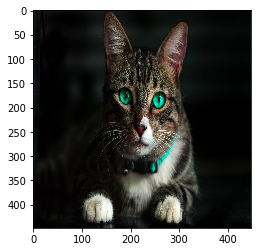

In [125]:
# Read in a cat image and resize it to
# a preset size
height = width = 448
num_channels = 3
img = cv2.imread("images/cat2.jpeg")
img = cv2.resize(img, (height, width))

#Convert to RGB from OpenCV's native BGR 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print("Image size is {}".format(img.shape))

# Divide the image into 16 * 16 patches 
# and treat each patch as a vector
patch_size = 16
num_patches = (height * width) / (patch_size
                                  * patch_size)
# Each patch is an observation. We treat each channel
# to be independent
# Feature vector size = patch_size * patch_size
X = np.zeros((num_channels, num_patches,
              patch_size * patch_size))
num_patches_row = height / patch_size
num_patches_col = width / patch_size
for i in range(num_patches_row):
    for j in range(num_patches_col):
        for k in range(num_channels):
            # Create a data row representing the patch
            # Numpy ravel creates a 1D flattened array
            # from its inputs. In this case, it creates
            # an input array from the patch pixels.
            X[k, i*num_patches_col+j, :] = \
            np.ravel(img[j*patch_size:(j+1)*patch_size,
                         i*patch_size: (i+1)*patch_size,
                         k])

print("Patches dataset shape is {}".format(X.shape))

plt.imshow(img)
plt.show()

per_channel_pca = {}
# Let us apply PCA per channel independently
for i in range(num_channels):
    principal_values, principal_components = pca(X[i])
    per_channel_pca[i] = {"principal_values": principal_values,
                          "principal_components": principal_components}

Using 1 components
Original image size: 602112
Compressed image size: 2352
Compression ratio is : 256.0
Number of zeros 56144


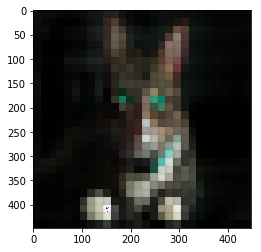

Using 50 components
Original image size: 602112
Compressed image size: 117600
Compression ratio is : 5.12
Number of zeros 67114


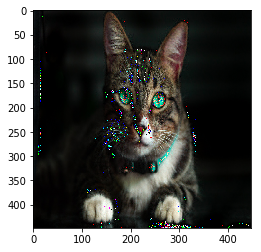

Using 100 components
Original image size: 602112
Compressed image size: 235200
Compression ratio is : 2.56
Number of zeros 67844


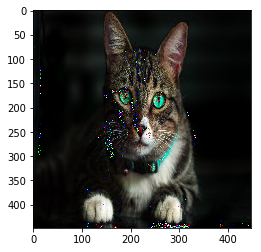

Using 200 components
Original image size: 602112
Compressed image size: 470400
Compression ratio is : 1.28
Number of zeros 68937


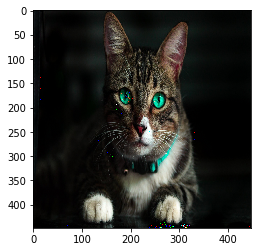

In [136]:
def print_info(orig_img, compressed_img):
    print("Original image size: {}".\
          format(orig_img.size))
    print("Compressed image size: {}".\
          format(compressed_img.size))
    print("Compression ratio is : {}".
          format( (orig_img.size * 1.0) 
                  / (compressed_img.size)))
    
def compress(channel, num_components,
             principal_values=None,
             principal_components=None):
    """
    Compresses the channel and returns
    compressed channel information.
    Original channel is to be represented as
    data matrix with each row representing a
    patch - all pixels in the patch flattened out
    into a 1D array.
    Compression is done by retaining only the
    principal_components corresponding
    to top num_components principal values for each
    patch.
    """
    # Assert that the image is represented as matrix
    assert len(channel.shape) == 2
    if principal_values is None\
       or principal_components is None:
        # do PCA if not provided
        principal_values,  principal_components =\
            pca(channel)
    assert num_components <=  len(principal_values)
    
    # sort in decreasing order of principal values
    sorted_indices = np.argsort(-principal_values)
    
    # Only retain top principal components
    retained_indices =\
       sorted_indices[: num_components]
    projection_matrix = \
        principal_components[:, retained_indices]
    compressed_channel = np.dot(channel,
                            projection_matrix)
    return projection_matrix, compressed_channel

def decompress(projection_matrix,
               compressed_channel):
    """
    Decompresses a given compressed channel using the 
    inverse of the projection matrix
    """
    return np.dot(compressed_channel,
                              np.linalg.pinv(projection_matrix))
    

def get_canonical_image(img, height, width,
                        num_channels, patch_size):
    """
    Returns canoncial image representation 
    i.e RGB from patch feature representation
    """
    canonical_img = np.zeros((height, width, num_channels),
                             dtype=np.uint8)
    num_patches_row = height / patch_size
    num_patches_col = width / patch_size
    for i in range(num_patches_row):
        for j in range(num_patches_col):
            for k in range(num_channels):
                canonical_img[j*patch_size:(j+1)*patch_size,\
                          i*patch_size: (i+1)*patch_size,\
                          k] = img[k , i*num_patches_col+j, :]\
            .reshape((patch_size, patch_size))
    return canonical_img 


for num_components in [1, 50, 100, 200]:
    # Let us compress the image by selecting 
    # only num_components principal components
    print("Using %d components"%(num_components))
    decompressed_img = np.zeros_like(X)
    compressed_img = np.zeros([num_channels, X.shape[1], num_components])
    for i in range(num_channels):
        projection_matrix, compressed_channel =\
            compress(X[i], num_components,
                 per_channel_pca[i]["principal_values"],
                 per_channel_pca[i]["principal_components"])
        compressed_img[i, :, :] = compressed_channel
        decompressed_img[i, :, :] = decompress(projection_matrix,
                                  compressed_channel)
    print_info(img, compressed_img)
    canonical_img = get_canonical_image(decompressed_img,
                                        height, width,
                                        num_channels,
                                        patch_size)
    print("Number of zeros {}".format(canonical_img[np.where(canonical_img <= 0.5)].size))
    plt.imshow(np.squeeze(canonical_img), cmap="gray")
    plt.show()